# Improving Data Quality

**Learning Objectives**


1. Resolve missing values
2. Convert the Date feature column to a datetime format
3. Rename a feature column, remove a value from a feature column
4. Create one-hot encoding features
5. Understand temporal feature conversions 


## Introduction 

Recall that machine learning models can only consume numeric data, and that numeric data should be "1"s or "0"s.  Data is said to be "messy" or "untidy" if it is missing attribute values, contains noise or outliers, has duplicates, wrong data, upper/lower case column names, and is essentially not ready for ingestion by a machine learning algorithm.  

This notebook presents and solves some of the most common issues of "untidy" data.  Note that different problems will require different methods, and they are beyond the scope of this notebook.

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/launching_into_ml/labs/improve_data_quality.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

In [164]:
# Use the chown command to change the ownership of the repository to user
# !sudo chown -R everyone:everyone /Users/dduru/VSCode/Private/ML/training-data-analyst

### Import Libraries

In [165]:
# Importing necessary tensorflow library and printing the TF version.
import tensorflow as tf

print("TensorFlow version: ",tf.version.VERSION)


TensorFlow version:  2.12.0


In [166]:
import os
# Here we'll import Pandas and Numpy data processing libraries
import pandas as pd  
import numpy as np
from datetime import datetime
# Use matplotlib for visualizing the model
import matplotlib.pyplot as plt
# Use seaborn for data visualization
import seaborn as sns
%matplotlib inline

### Load the Dataset

The dataset is based on California's [Vehicle Fuel Type Count by Zip Code](https://data.ca.gov/dataset/vehicle-fuel-type-count-by-zip-codeSynthetic) report.  The dataset has been modified to make the data "untidy" and is thus a synthetic representation that can be used for learning purposes.  


In [167]:
# Creating directory to store dataset
if not os.path.isdir("../data/transport"):
    os.makedirs("../data/transport")

In [168]:
# Download the raw .csv data by copying the data from a cloud storage bucket.
!gsutil cp gs://cloud-training/mlongcp/v3.0_MLonGC/toy_data/untidy_vehicle_data_toy.csv ../data/transport

Copying gs://cloud-training/mlongcp/v3.0_MLonGC/toy_data/untidy_vehicle_data_toy.csv...
- [1 files][ 23.7 KiB/ 23.7 KiB]                                                
Operation completed over 1 objects/23.7 KiB.                                     


In [169]:
# ls shows the working directory's contents.
# Using the -l parameter will lists files with assigned permissions
!ls -l ../data/transport

total 48
-rw-r--r--  1 dduru  staff  24263 May  6 17:06 untidy_vehicle_data_toy.csv


### Read Dataset into a Pandas DataFrame

Next, let's read in the dataset just copied from the cloud storage bucket and create a Pandas DataFrame.  We also add a Pandas .head() function to show you the top 5 rows of data in the DataFrame. Head() and Tail() are "best-practice" functions used to investigate datasets.  

In [170]:
# Reading "untidy_vehicle_data_toy.csv" file using the read_csv() function included in the pandas library.
df_transport = pd.read_csv('../data/transport/untidy_vehicle_data_toy.csv')

# Output the first five rows.
df_transport.head() 

,Date,Zip Code,Model Year,Fuel,Make,Light_Duty,Vehicles
0,10/1/2018,90000.0,2006,Gasoline,OTHER/UNK,NaN,1.0
1,10/1/2018,NaN,2014,Gasoline,NaN,Yes,1.0
2,NaN,90000.0,NaN,Gasoline,OTHER/UNK,Yes,NaN
3,10/1/2018,90000.0,2017,Gasoline,OTHER/UNK,Yes,1.0
4,10/1/2018,90000.0,<2006,Diesel and Diesel Hybrid,OTHER/UNK,No,55.0


### DataFrame Column Data Types

DataFrames may have heterogenous or "mixed" data types, that is, some columns are numbers, some are strings, and some are dates etc. Because CSV files do not contain information on what data types are contained in each column, Pandas infers the data types when loading the data, e.g. if a column contains only numbers, Pandas will set that column’s data type to numeric: integer or float.

Run the next cell to see information on the DataFrame.

In [171]:
# The .info() function will display the concise summary of an dataframe.
df_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        497 non-null    object 
 1   Zip Code    497 non-null    float64
 2   Model Year  497 non-null    object 
 3   Fuel        497 non-null    object 
 4   Make        496 non-null    object 
 5   Light_Duty  496 non-null    object 
 6   Vehicles    496 non-null    float64
dtypes: float64(2), object(5)
memory usage: 27.4+ KB


From what the .info() function shows us, we have six string objects and one float object. We can definitely see more of the "string" object values now!

In [172]:
# Let's print out the first and last five rows of each column.
print(df_transport,5)

          Date  Zip Code Model Year                      Fuel       Make  \
0    10/1/2018   90000.0       2006                  Gasoline  OTHER/UNK   
1    10/1/2018       NaN       2014                  Gasoline        NaN   
2          NaN   90000.0        NaN                  Gasoline  OTHER/UNK   
3    10/1/2018   90000.0       2017                  Gasoline  OTHER/UNK   
4    10/1/2018   90000.0      <2006  Diesel and Diesel Hybrid  OTHER/UNK   
..         ...       ...        ...                       ...        ...   
494  12/3/2018   90002.0       2010                  Gasoline     Type_I   
495  12/4/2018   90002.0       2010                  Gasoline     Type_B   
496  12/5/2018   90002.0       2010                  Gasoline     Type_C   
497  12/6/2018   90002.0       2010                  Gasoline     Type_J   
498  12/7/2018   90002.0       2010                  Gasoline     Type_J   

    Light_Duty  Vehicles  
0          NaN       1.0  
1          Yes       1.0  
2     

### Summary Statistics 

At this point, we have only one column which contains a numerical value (e.g. Vehicles).  For features which contain numerical values, we are often interested in various statistical measures relating to those values. Note, that because we only have one numeric feature, we see only one summary stastic - for now.  

In [173]:
# We can use .describe() to see some summary statistics for the numeric fields in our dataframe.
df_transport.describe()

,Zip Code,Vehicles
count,497.00000,496.000000
mean,89838.23340,74.512097
std,3633.35609,243.839871
min,9001.00000,1.000000
25%,90001.00000,14.000000
50%,90001.00000,25.000000
75%,90001.00000,56.250000
max,90002.00000,3178.000000


Let's investigate a bit more of our data by using the .groupby() function.

In [174]:
# The .groupby() function is used for spliting the data into groups based on some criteria.
grouped_data = df_transport.groupby(['Zip Code','Model Year','Fuel','Make','Light_Duty','Vehicles'])
# grouped_data.first()

 # Get the first entry for each month.
df_transport.groupby('Fuel').first()

,Date,Zip Code,Model Year,Make,Light_Duty,Vehicles
Fuel,,,,,,
Battery Electric,10/1/2018,90000.0,<2006,OTHER/UNK,No,4.0
Diesel and Diesel Hybrid,10/1/2018,90000.0,<2006,OTHER/UNK,No,55.0
Flex-Fuel,10/14/2018,90001.0,2007,Type_A,Yes,78.0
Gasoline,10/1/2018,90000.0,2006,OTHER/UNK,Yes,1.0
Hybrid Gasoline,10/24/2018,90001.0,2009,OTHER/UNK,Yes,18.0
Natural Gas,10/25/2018,90001.0,2009,OTHER/UNK,No,2.0
Other,10/8/2018,90000.0,<2006,OTHER/UNK,Yes,6.0
Plug-in Hybrid,11/2/2018,90001.0,2012,OTHER/UNK,Yes,1.0


### Checking for Missing Values

Missing values adversely impact data quality, as they can lead the machine learning model to make inaccurate inferences about the data. Missing values can be the result of numerous factors, e.g. "bits" lost during streaming transmission, data entry, or perhaps a user forgot to fill in a field.  Note that Pandas recognizes both empty cells and “NaN” types as missing values. 

#### Let's show the null values for all features in the DataFrame.

In [175]:
df_transport.isnull().sum()

Date          2
Zip Code      2
Model Year    2
Fuel          2
Make          3
Light_Duty    3
Vehicles      3
dtype: int64

To see a sampling of which values are missing, enter the feature column name.  You'll notice that "False" and "True" correpond to the presence or abscence of a value by index number.

In [176]:
print (df_transport['Date'])
print (df_transport['Date'].isnull())

0      10/1/2018
1      10/1/2018
2            NaN
3      10/1/2018
4      10/1/2018
         ...    
494    12/3/2018
495    12/4/2018
496    12/5/2018
497    12/6/2018
498    12/7/2018
Name: Date, Length: 499, dtype: object
0      False
1      False
2       True
3      False
4      False
       ...  
494    False
495    False
496    False
497    False
498    False
Name: Date, Length: 499, dtype: bool


In [177]:
print (df_transport['Make'])
print (df_transport['Make'].isnull())

0      OTHER/UNK
1            NaN
2      OTHER/UNK
3      OTHER/UNK
4      OTHER/UNK
         ...    
494       Type_I
495       Type_B
496       Type_C
497       Type_J
498       Type_J
Name: Make, Length: 499, dtype: object
0      False
1       True
2      False
3      False
4      False
       ...  
494    False
495    False
496    False
497    False
498    False
Name: Make, Length: 499, dtype: bool


In [178]:
print (df_transport['Model Year'])
print (df_transport['Model Year'].isnull())

0       2006
1       2014
2        NaN
3       2017
4      <2006
       ...  
494     2010
495     2010
496     2010
497     2010
498     2010
Name: Model Year, Length: 499, dtype: object
0      False
1      False
2       True
3      False
4      False
       ...  
494    False
495    False
496    False
497    False
498    False
Name: Model Year, Length: 499, dtype: bool


### What can we deduce about the data at this point?


# Let's summarize our data by row, column, features, unique, and missing values.


In [179]:
# In Python shape() is used in pandas to give the number of rows/columns.
# The number of rows is given by .shape[0]. The number of columns is given by .shape[1].
# Thus, shape() consists of an array having two arguments -- rows and columns
print ("Rows     : " ,df_transport.shape[0])
print ("Columns  : " ,df_transport.shape[1])
print ("\nFeatures : \n" ,df_transport.columns.tolist())
print ("\nUnique values :  \n",df_transport.nunique())
print ("\nMissing values :  ", df_transport.isnull().sum().values.sum())



Rows     :  499
Columns  :  7

Features : 
 ['Date', 'Zip Code', 'Model Year', 'Fuel', 'Make', 'Light_Duty', 'Vehicles']

Unique values :  
 Date          130
Zip Code        4
Model Year     15
Fuel            8
Make           43
Light_Duty      2
Vehicles      151
dtype: int64

Missing values :   17


Let's see the data again -- this time the last five rows in the dataset.

In [180]:
# Output the last five rows in the dataset.
df_transport.tail(6)

,Date,Zip Code,Model Year,Fuel,Make,Light_Duty,Vehicles
493,12/2/2018,90002.0,2010,Gasoline,Type_A,Yes,36.0
494,12/3/2018,90002.0,2010,Gasoline,Type_I,Yes,11.0
495,12/4/2018,90002.0,2010,Gasoline,Type_B,Yes,58.0
496,12/5/2018,90002.0,2010,Gasoline,Type_C,Yes,45.0
497,12/6/2018,90002.0,2010,Gasoline,Type_J,Yes,82.0
498,12/7/2018,90002.0,2010,Gasoline,Type_J,Yes,12.0


### What Are Our Data Quality Issues?

1. **Data Quality Issue #1**:  
> **Missing Values**:
Each feature column has multiple missing values.  In fact, we have a total of 18 missing values.
2. **Data Quality Issue #2**: 
> **Date DataType**:  Date is shown as an "object" datatype and should be a datetime.  In addition, Date is in one column.  Our business requirement is to see the Date parsed out to year, month, and day.  
3. **Data Quality Issue #3**: 
> **Model Year**: We are only interested in years greater than 2006, not "<2006".
4. **Data Quality Issue #4**:  
> **Categorical Columns**:  The feature column "Light_Duty" is categorical and has a "Yes/No" choice.  We cannot feed values like this into a machine learning model.  In addition, we need to "one-hot encode the remaining "string"/"object" columns.
5. **Data Quality Issue #5**:  
> **Temporal Features**:  How do we handle year, month, and day?


#### Data Quality Issue #1:  
##### Resolving Missing Values

Most algorithms do not accept missing values.  Yet, when we see missing values in our dataset, there is always a tendency to just "drop all the rows" with missing values.  Although Pandas will fill in the blank space with “NaN", we should "handle" them in some way.

While all the methods to handle missing values is beyond the scope of this lab, there are a few methods you should consider.  For numeric columns, use the "mean" values to fill in the missing numeric values.  For categorical columns, use the "mode" (or most frequent values) to fill in missing categorical values. 

In this lab, we use the .apply and Lambda functions to fill every column with its own most frequent value.  You'll learn more about Lambda functions later in the lab.

Let's check again for missing values by showing how many rows contain NaN values for each feature column.

In [181]:
# The isnull() method is used to check and manage NULL values in a data frame.
# TODO 1a
df_transport.isnull().sum()

Date          2
Zip Code      2
Model Year    2
Fuel          2
Make          3
Light_Duty    3
Vehicles      3
dtype: int64

Run the cell to apply the lambda function.

In [182]:
# Here we are using the apply function with lambda.
# We can use the apply() function to apply the lambda function to both rows and columns of a dataframe.
# TODO 1b
df_transport = df_transport.apply(lambda x:x.fillna(x.value_counts().index[0]))

Let's check again for missing values.

In [183]:
# The isnull() method is used to check and manage NULL values in a data frame.
# TODO 1c
df_transport.isnull().sum()

Date          0
Zip Code      0
Model Year    0
Fuel          0
Make          0
Light_Duty    0
Vehicles      0
dtype: int64

#### Data Quality Issue #2:  
##### Convert the Date Feature Column to a Datetime Format

In [184]:
# The date column is indeed shown as a string object. We can convert it to the datetime datatype with the to_datetime() function in Pandas.
# TODO 2a
df_transport['Date'] =  pd.to_datetime(df_transport['Date'],
                              format='%m/%d/%Y')

In [185]:
# Date is now converted and will display the concise summary of an dataframe.
# TODO 2b
df_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        499 non-null    datetime64[ns]
 1   Zip Code    499 non-null    float64       
 2   Model Year  499 non-null    object        
 3   Fuel        499 non-null    object        
 4   Make        499 non-null    object        
 5   Light_Duty  499 non-null    object        
 6   Vehicles    499 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 27.4+ KB


In [186]:
# Now we will parse Date into three columns that is year, month, and day.
df_transport['year'] = df_transport['Date'].dt.year
df_transport['month'] = df_transport['Date'].dt.month
df_transport['day'] = df_transport['Date'].dt.day

#df['hour'] = df['date'].dt.hour - you could use this if your date format included hour.
#df['minute'] = df['date'].dt.minute - you could use this if your date format included minute.

# The .info() function will display the concise summary of an dataframe.
df_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        499 non-null    datetime64[ns]
 1   Zip Code    499 non-null    float64       
 2   Model Year  499 non-null    object        
 3   Fuel        499 non-null    object        
 4   Make        499 non-null    object        
 5   Light_Duty  499 non-null    object        
 6   Vehicles    499 non-null    float64       
 7   year        499 non-null    int32         
 8   month       499 non-null    int32         
 9   day         499 non-null    int32         
dtypes: datetime64[ns](1), float64(2), int32(3), object(4)
memory usage: 33.3+ KB


Let's confirm the Date parsing. This will also give us a another visualization of the data.

In [187]:
# Here, we are creating a new dataframe called "grouped_data" and grouping by on the column "Make"
grouped_data = df_transport.groupby(['Make'])

# Get the first entry for each month.
df_transport.groupby('month').first()

,Date,Zip Code,Model Year,Fuel,Make,Light_Duty,Vehicles,year,day
month,,,,,,,,,
1,2019-01-01,90001.0,2016,Gasoline,Type_G,Yes,18.0,2019,1
2,2019-02-01,90001.0,2017,Gasoline,Type_D,Yes,13.0,2019,1
3,2019-03-01,90001.0,2018,Gasoline,Type_C,Yes,32.0,2019,1
10,2018-10-01,90000.0,2006,Gasoline,OTHER/UNK,Yes,1.0,2018,1
11,2018-11-01,90001.0,2007,Gasoline,Type_M,Yes,15.0,2018,1
12,2018-12-02,90001.0,2015,Gasoline,Type_G,Yes,19.0,2018,2


Now that we have Dates as a integers, let's do some additional plotting.

/opt/homebrew/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Vehicles by Month')

<Figure size 1000x600 with 0 Axes>

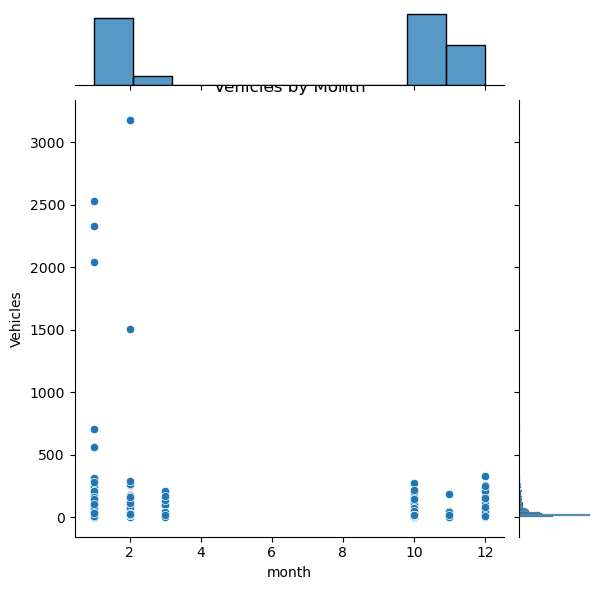

In [188]:
# Here we will visualize our data using the figure() function in the pyplot module of matplotlib's library -- which is used to create a new figure.
plt.figure(figsize=(10,6))

# Seaborn's .jointplot() displays a relationship between 2 variables (bivariate) as well as 1D profiles (univariate) in the margins. This plot is a convenience class that wraps JointGrid.
sns.jointplot(x='month',y='Vehicles',data=df_transport)

# The title() method in matplotlib module is used to specify title of the visualization depicted and displays the title using various attributes.
plt.title('Vehicles by Month')

#### Data Quality Issue #3:  
##### Rename a Feature Column and Remove a Value.  

Our feature columns have different "capitalizations" in their names, e.g. both upper and lower "case".  In addition, there are "spaces" in some of the column names.  In addition, we are only interested in years greater than 2006, not "<2006".  

We can also resolve the "case" problem too by making all the feature column names lower case.

In [189]:
# Let's remove all the spaces for feature columns by renaming them.
# TODO 3a
df_transport.rename(columns = { 'Date': 'date', 'Zip Code':'zipcode', 'Model Year': 'modelyear', 'Fuel': 'fuel', 'Make': 'make', 'Light_Duty': 'lightduty', 'Vehicles': 'vehicles'}, inplace = True) 

# Output the first two rows.
df_transport.head(2)

,date,zipcode,modelyear,fuel,make,lightduty,vehicles,year,month,day
0,2018-10-01,90000.0,2006,Gasoline,OTHER/UNK,Yes,1.0,2018,10,1
1,2018-10-01,90001.0,2014,Gasoline,OTHER/UNK,Yes,1.0,2018,10,1


 **Note:** Next we create a copy of the dataframe to avoid the "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame" warning.  Run the cell to remove the value '<2006' from the modelyear feature column. 

In [190]:
# Here, we create a copy of the dataframe to avoid copy warning issues.
# TODO 3b
df = df_transport.loc[df_transport.modelyear != '<2006'].copy()

In [191]:
# Here we will confirm that the modelyear value '<2006' has been removed by doing a value count.
df['modelyear'].value_counts(0)

modelyear
2007    53
2008    45
2006    36
2010    34
2014    31
2015    30
2017    29
2016    29
2013    27
2009    25
2012    25
2011    24
2018    23
2019     5
Name: count, dtype: int64

#### Data Quality Issue #4:  
##### Handling Categorical Columns

The feature column "lightduty" is categorical and has a "Yes/No" choice.  We cannot feed values like this into a machine learning model.  We need to convert the binary answers from strings of yes/no to integers of 1/0.  There are various methods to achieve this.  We will use the "apply" method with a lambda expression.  Pandas. apply() takes a function and applies it to all values of a Pandas series.

##### What is a Lambda Function?

Typically, Python requires that you define a function using the def keyword. However, lambda functions are anonymous -- which means there is no need to name them. The most common use case for lambda functions is in code that requires a simple one-line function (e.g. lambdas only have a single expression).  

As you progress through the Course Specialization, you will see many examples where lambda functions are being used.  Now is a good time to become familiar with them.

In [192]:
# Lets count the number of "Yes" and"No's" in the 'lightduty' feature column.
df['lightduty'].value_counts(0)

lightduty
Yes    374
No      42
Name: count, dtype: int64

In [193]:
# Let's convert the Yes to 1 and No to 0.
# The .apply takes a function and applies it to all values of a Pandas series (e.g. lightduty). 
df.loc[:,'lightduty'] = df['lightduty'].apply(lambda x: 0 if x=='No' else 1)
df['lightduty'].value_counts(0)

lightduty
1    374
0     42
Name: count, dtype: int64

In [197]:
# Confirm that "lightduty" has been converted.
df.head()
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'date': <DatetimeArray>
['2018-10-01 00:00:00', '2018-10-09 00:00:00', '2018-10-10 00:00:00',
 '2018-10-11 00:00:00', '2018-10-12 00:00:00', '2018-10-13 00:00:00',
 '2018-10-14 00:00:00', '2018-10-15 00:00:00', '2018-10-16 00:00:00',
 '2018-10-17 00:00:00',
 ...
 '2019-02-27 00:00:00', '2019-02-28 00:00:00', '2019-03-01 00:00:00',
 '2019-03-02 00:00:00', '2019-03-03 00:00:00', '2019-03-04 00:00:00',
 '2019-03-05 00:00:00', '2019-03-06 00:00:00', '2019-03-07 00:00:00',
 '2019-03-08 00:00:00']
Length: 130, dtype: datetime64[ns]
Unique values in 'zipcode': [90000. 90001.  9001. 90002.]
Unique values in 'modelyear': ['2006' '2014' '2017' '2007' '2008' '2009' '2010' '2011' '2012' '2013'
 '2015' '2016' '2018' '2019']
Unique values in 'fuel': ['Gasoline' 'Diesel and Diesel Hybrid' 'Flex-Fuel' 'Battery Electric'
 'Hybrid Gasoline' 'Natural Gas' 'Plug-in Hybrid']
Unique values in 'make': ['OTHER/UNK' 'Type_C' 'Type_A' 'Type_F' 'Type_G' 'Type_H' 'Type_I'
 'Type_B' 'Type_D' 'Type

#### One-Hot Encoding Categorical Feature Columns

Machine learning algorithms expect input vectors and not categorical features. Specifically, they cannot handle text or string values.  Thus, it is often useful to transform categorical features into vectors.

One transformation method is to create dummy variables for our categorical features.  Dummy variables are a set of binary (0 or 1) variables that each represent a single class from a categorical feature.  We simply  encode the categorical variable as a one-hot vector, i.e. a vector where only one element is non-zero, or hot.  With one-hot encoding, a categorical feature becomes an array whose size is the number of possible choices for that feature.

Panda provides a function called "get_dummies" to convert a categorical variable into dummy/indicator variables.

In [199]:
# Making dummy variables for categorical data with more inputs.  
data_dummy = pd.get_dummies(df[['zipcode','modelyear', 'fuel', 'make']], drop_first=True)

# data_dummy.shape[0]

# Output the first five rows.
# data_dummy.head()




# data_dummy.columns
# print(df['zipcode'].nunique())

df['zipcode'].dtype

dtype('float64')

In [120]:
# Merging (concatenate) original data frame with 'dummy' dataframe.
# TODO 4a
df = pd.concat([df,data_dummy], axis=1)
df.head()

,date,zipcode,modelyear,fuel,make,lightduty,vehicles,year,month,day,...,make_Type_P,make_Type_Q,make_Type_R,make_Type_S,make_Type_T,make_Type_U,make_Type_V,make_Type_W,make_Type_X,make_Type_Y
0,2018-10-01,90000.0,2006,Gasoline,OTHER/UNK,1,1.0,2018,10,1,...,False,False,False,False,False,False,False,False,False,False
1,2018-10-01,90001.0,2014,Gasoline,OTHER/UNK,1,1.0,2018,10,1,...,False,False,False,False,False,False,False,False,False,False
3,2018-10-01,90000.0,2017,Gasoline,OTHER/UNK,1,1.0,2018,10,1,...,False,False,False,False,False,False,False,False,False,False
16,2018-10-09,90001.0,2006,Diesel and Diesel Hybrid,Type_C,0,16.0,2018,10,9,...,False,False,False,False,False,False,False,False,False,False
17,2018-10-10,90001.0,2006,Diesel and Diesel Hybrid,OTHER/UNK,0,23.0,2018,10,10,...,False,False,False,False,False,False,False,False,False,False


In [121]:
# Dropping attributes for which we made dummy variables.  Let's also drop the Date column.
# TODO 4b
# Date,Zip Code,Model Year,Fuel,Make,Light_Duty,Vehicles
df = df.drop(['date','zipcode','modelyear', 'fuel', 'make'], axis=1)


In [130]:
# Confirm that 'zipcode','modelyear', 'fuel', and 'make' have been dropped.
# df.head()

print(df.columns)

df.head()

Index(['lightduty', 'vehicles', 'modelyear_2007', 'modelyear_2008',
       'modelyear_2009', 'modelyear_2010', 'modelyear_2011', 'modelyear_2012',
       'modelyear_2013', 'modelyear_2014', 'modelyear_2015', 'modelyear_2016',
       'modelyear_2017', 'modelyear_2018', 'modelyear_2019',
       'fuel_Diesel and Diesel Hybrid', 'fuel_Flex-Fuel', 'fuel_Gasoline',
       'fuel_Hybrid Gasoline', 'fuel_Natural Gas', 'fuel_Plug-in Hybrid',
       'make_Type_A', 'make_Type_B', 'make_Type_C', 'make_Type_D',
       'make_Type_F', 'make_Type_FF', 'make_Type_G', 'make_Type_GG',
       'make_Type_H', 'make_Type_I', 'make_Type_II', 'make_Type_J',
       'make_Type_K', 'make_Type_L', 'make_Type_M', 'make_Type_MM',
       'make_Type_N', 'make_Type_NN', 'make_Type_O', 'make_Type_P',
       'make_Type_Q', 'make_Type_R', 'make_Type_S', 'make_Type_T',
       'make_Type_U', 'make_Type_V', 'make_Type_W', 'make_Type_X',
       'make_Type_Y', 'day_sin', 'day_cos', 'month_sin', 'month_cos'],
      dtype='object

,lightduty,vehicles,modelyear_2007,modelyear_2008,modelyear_2009,modelyear_2010,modelyear_2011,modelyear_2012,modelyear_2013,modelyear_2014,...,make_Type_T,make_Type_U,make_Type_V,make_Type_W,make_Type_X,make_Type_Y,day_sin,day_cos,month_sin,month_cos
0,1,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.201299,0.979530,-1.0,-1.836970e-16
1,1,1.0,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,0.201299,0.979530,-1.0,-1.836970e-16
3,1,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.201299,0.979530,-1.0,-1.836970e-16
16,0,16.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.968077,-0.250653,-1.0,-1.836970e-16
17,0,23.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.897805,-0.440394,-1.0,-1.836970e-16


#### Data Quality Issue #5:  
##### Temporal Feature Columns

Our dataset now contains year, month, and day feature columns.  Let's convert the month and day feature columns to meaningful representations as a way to get us thinking about changing temporal features -- as they are sometimes overlooked.  

Note that the Feature Engineering course in this Specialization will provide more depth on methods to handle year, month, day, and hour feature columns.


In [124]:

print ('Unique values of month:',df.month.unique())
print ('Unique values of day:',df.day.unique())
print ('Unique values of year:',df.year.unique())

Unique values of month: [10 11 12  1  2  3]
Unique values of day: [ 1  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
  2  3  4  5  6  7  8]
Unique values of year: [2018 2019]


Don't worry, this is the last time we will use this code, as you can develop an input pipeline to address these temporal feature columns in TensorFlow and Keras - and it is much easier!  But, sometimes you need to appreciate what you're not going to encounter as you move through the course!

Run the cell to view the output.

In [125]:
# Here we map each temporal variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using the sin and cos trigonometric functions.
df['day_sin'] = np.sin(df.day*(2.*np.pi/31))
df['day_cos'] = np.cos(df.day*(2.*np.pi/31))
df['month_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
df['month_cos'] = np.cos((df.month-1)*(2.*np.pi/12))

# Let's drop month, and day
# TODO 5
df = df.drop(['month','day','year'], axis=1)

In [163]:
# scroll left to see the converted month and day coluumns.
df.tail(4)

,date,zipcode,modelyear,fuel,make,lightduty,vehicles,year,month,day
495,2018-12-04,90002.0,2010,Gasoline,Type_B,1,58.0,2018,12,4
496,2018-12-05,90002.0,2010,Gasoline,Type_C,1,45.0,2018,12,5
497,2018-12-06,90002.0,2010,Gasoline,Type_J,1,82.0,2018,12,6
498,2018-12-07,90002.0,2010,Gasoline,Type_J,1,12.0,2018,12,7


### Conclusion

This notebook introduced a few concepts to improve data quality.  We resolved missing values, converted the Date feature column to a datetime format, renamed feature columns, removed a value from a feature column, created one-hot encoding features, and converted temporal features to meaningful representations.  By the end of our lab, we gained an understanding as to why data should be "cleaned" and "pre-processed" before input into a machine learning model.

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.